# Goals
1. to create a feature matrix comprising both blockchain data and Twitter data
2. min-max normalize the data
3. cut some features off as per Pearson correlation threshold test
4. visualize the remaining features to see if they make basic sense
5. perform Granger causality tests
6. export the processed features to a form accessible by RapidMiner for further analysis

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import grangercausalitytests

# def flatten_list(lists):
#     return functools.reduce(operator.iconcat, lists, [])

# def counter_sort(counter):
#     return sorted(counter.items(), key=lambda item: item[1], reverse=True)

# import time
# start_time = time.time()
# main()
# print("--- %s seconds ---" % (time.time() - start_time))

# Read blockchain data

In [2]:
df = pd.read_csv('data/Final.csv', parse_dates=['Date(UTC)'], index_col='Date(UTC)')
df.head()
df.tail()

,Price,MarketCap,Supply,TxGrowth,AddressCount,BlockSize,BlockTime,AvgGasPrice,GasUsed,NetworkHash,TransactionFee,NetworkUtilization,BlockReward
Date(UTC),,,,,,,,,,,,,
2015-08-07,2.77,200.215391,7.227992e+07,2050,10314,633,16.65,604684154870,49353826,95.2981,37318413511279304835,0.1317,27437.65625
2015-08-08,0.81,58.569373,7.230787e+07,2881,10730,668,16.44,322713574989,376006093,104.8971,68099970071856826797,0.0468,27943.43750
2015-08-09,0.74,53.527934,7.233505e+07,1329,11004,618,16.86,475467129048,38863003,109.6916,14098949703205590944,0.0024,27178.28125
2015-08-10,0.68,49.206747,7.236286e+07,2037,11679,631,16.44,421654904254,74070061,120.5988,31165144438378735884,0.0045,27817.34375
2015-08-11,1.06,76.734345,7.239089e+07,4963,13576,692,16.37,77838819162,163481740,134.7695,11311448586019755030,0.0099,28027.81250


,Price,MarketCap,Supply,TxGrowth,AddressCount,BlockSize,BlockTime,AvgGasPrice,GasUsed,NetworkHash,TransactionFee,NetworkUtilization,BlockReward
Date(UTC),,,,,,,,,,,,,
2020-03-20,133.40,14697.986350,1.101798e+08,822158,91036713,27084,13.23,16360326781,56053109603,174054.6792,723896225190783765996,0.8759,13609.6250
2020-03-21,132.72,14624.893908,1.101936e+08,857503,91238528,26578,13.13,12414614632,54089637190,180106.6438,517400525170320857993,0.8443,13787.1250
2020-03-22,122.44,13493.757772,1.102071e+08,746195,91363429,25601,13.52,12942212470,51420600526,171178.0093,500344847372340294365,0.8234,13508.8125
2020-03-23,136.74,15071.610468,1.102209e+08,801238,91512903,25426,13.09,14465400762,51973418456,175188.2453,590391078944868076905,0.8161,13830.0000
2020-03-24,136.77,15076.775638,1.102345e+08,791900,91621035,26101,13.36,13687447647,51697161721,177982.9948,561403051931441313146,0.8250,13588.8125


# Plot price data

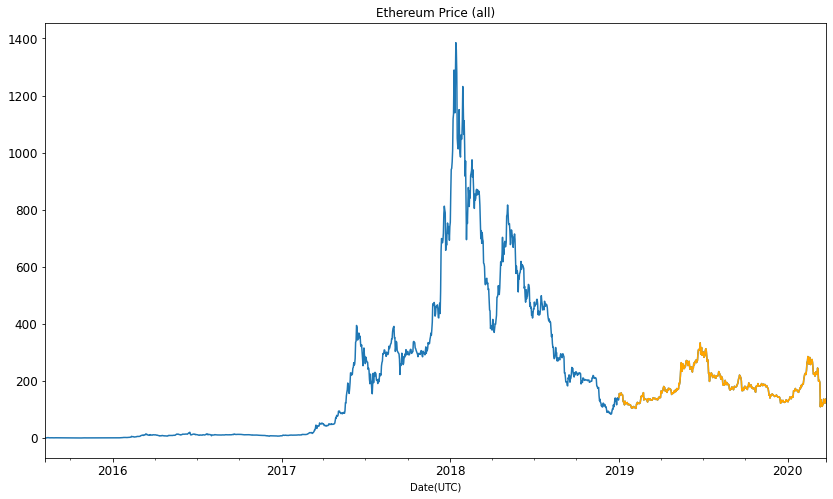

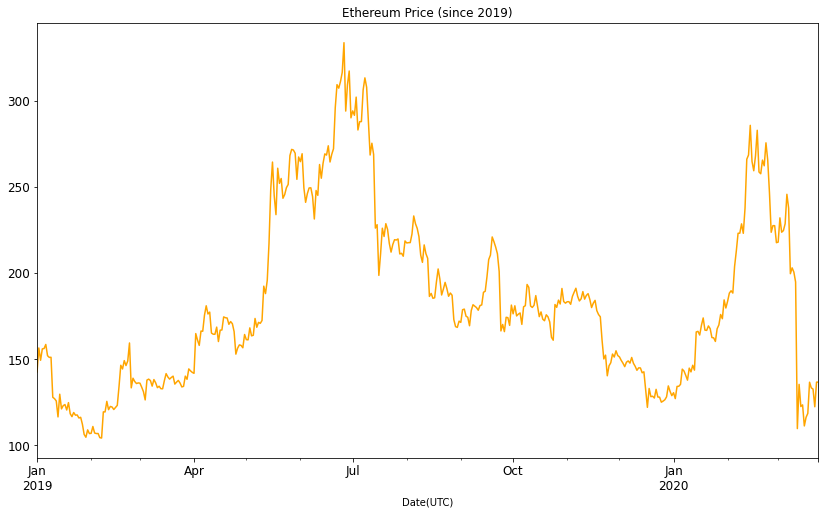

In [3]:
df.Price.plot(figsize=(14, 8), title='Ethereum Price (all)', fontsize=12)
df['Price']['2019-01-01':].plot(color='orange')
plt.show();
df['Price']['2019-01-01':].plot(figsize=(14, 8), title='Ethereum Price (since 2019)', fontsize=12, color='orange')
plt.show();

# Normalization (min-max) except Price

In [4]:
df = df.astype(float)
df_temp = df.copy()
df_temp = df_temp['Price'].to_frame()
df = (df - df.min()) / (df.max() - df.min())
del df['Price']
df = pd.concat([df_temp, df], axis=1)
df

,Price,MarketCap,Supply,TxGrowth,AddressCount,BlockSize,BlockTime,AvgGasPrice,GasUsed,NetworkHash,TransactionFee,NetworkUtilization,BlockReward
Date(UTC),,,,,,,,,,,,,
2015-08-07,2.77,0.001248,0.000000,0.000535,0.000000,0.000260,0.215844,0.640764,0.000171,0.000000,0.005431,0.133768,0.652755
2015-08-08,0.81,0.000193,0.000736,0.001151,0.000005,0.000868,0.203789,0.338307,0.005505,0.000032,0.010687,0.045934,0.672025
2015-08-09,0.74,0.000156,0.001452,0.000000,0.000008,0.000000,0.227899,0.502159,0.000000,0.000049,0.001467,0.000000,0.642873
2015-08-10,0.68,0.000123,0.002185,0.000525,0.000015,0.000226,0.203789,0.444437,0.000575,0.000086,0.004381,0.002173,0.667221
2015-08-11,1.06,0.000328,0.002924,0.002695,0.000036,0.001285,0.199770,0.075641,0.002035,0.000133,0.000991,0.007759,0.675240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-20,133.40,0.109228,0.998558,0.608670,0.993622,0.459463,0.019518,0.009696,0.914582,0.588065,0.122654,0.903683,0.125918
2020-03-21,132.72,0.108684,0.998922,0.634880,0.995825,0.450679,0.013777,0.005464,0.882524,0.608523,0.087398,0.870991,0.132681
2020-03-22,122.44,0.100259,0.999278,0.552341,0.997188,0.433718,0.036165,0.006030,0.838944,0.578340,0.084486,0.849369,0.122077


# Below shows features that are correlated by Pearson correlation (absolute value) of at least 0.8. From this, we sensically remove the following features: MarketCap, NetworkUtilization, GasUsed, BlockSize, and Supply.

In [5]:
print('---- Before Pearson correlation threshold test ----')
df.corr()[(df.corr() > 0.8) | (df.corr() < -0.8)]
del df['MarketCap'], df['NetworkUtilization'], df['GasUsed'], df['BlockSize'], df['Supply']
print('---- After Pearson correlation threshold test (some features intentionally not removed) ----')
df.corr()[(df.corr() > 0.8) | (df.corr() < -0.8)]

---- Before Pearson correlation threshold test ----


,Price,MarketCap,Supply,TxGrowth,AddressCount,BlockSize,BlockTime,AvgGasPrice,GasUsed,NetworkHash,TransactionFee,NetworkUtilization,BlockReward
Price,1.000000,0.998992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarketCap,0.998992,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Supply,NaN,NaN,1.000000,0.845749,0.893601,0.875053,NaN,NaN,0.918120,0.815249,NaN,0.893164,-0.840139
TxGrowth,NaN,NaN,0.845749,1.000000,NaN,0.958807,NaN,NaN,0.946724,0.879161,NaN,0.936585,-0.810912
AddressCount,NaN,NaN,0.893601,NaN,1.000000,NaN,NaN,NaN,0.894124,NaN,NaN,NaN,-0.887067
BlockSize,NaN,NaN,0.875053,0.958807,NaN,1.000000,NaN,NaN,0.947529,0.893175,NaN,0.964591,-0.860146
BlockTime,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
AvgGasPrice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
GasUsed,NaN,NaN,0.918120,0.946724,0.894124,0.947529,NaN,NaN,1.000000,0.906743,NaN,0.946507,-0.882196
NetworkHash,NaN,NaN,0.815249,0.879161,NaN,0.893175,NaN,NaN,0.906743,1.000000,NaN,0.904271,NaN


---- After Pearson correlation threshold test (some features intentionally not removed) ----


,Price,TxGrowth,AddressCount,BlockTime,AvgGasPrice,NetworkHash,TransactionFee,BlockReward
Price,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TxGrowth,NaN,1.000000,NaN,NaN,NaN,0.879161,NaN,-0.810912
AddressCount,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-0.887067
BlockTime,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
AvgGasPrice,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
NetworkHash,NaN,0.879161,NaN,NaN,NaN,1.000000,NaN,NaN
TransactionFee,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
BlockReward,NaN,-0.810912,-0.887067,NaN,NaN,NaN,NaN,1.000000


# Description of blockchain dataset

In [6]:
df.describe()

,Price,TxGrowth,AddressCount,BlockTime,AvgGasPrice,NetworkHash,TransactionFee,BlockReward
count,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000
mean,202.348038,0.291023,0.314708,0.131738,0.022300,0.382074,0.063434,0.462654
std,235.582870,0.238111,0.334808,0.154889,0.043709,0.334873,0.086146,0.265479
min,0.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.550000,0.031826,0.006822,0.053961,0.007525,0.017588,0.005446,0.189635
50%,152.310000,0.350031,0.137574,0.079793,0.016056,0.419632,0.054747,0.390955
75%,279.172500,0.491256,0.610801,0.165327,0.019697,0.617435,0.081417,0.726006
max,1385.020000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Import Twitter data and integrate with blockchain data

In [7]:
df2 = pd.read_csv('data/tweets_influencers.csv', parse_dates=['time'], index_col='time')
df2 = df2['2015-08-07':'2020-03-24']
df2 = df2[['count', 'likes_avg', 'retweets_avg', 'sentiment_avg']]
df3 = pd.concat([df, df2], axis=1)
df3

,Price,TxGrowth,AddressCount,BlockTime,AvgGasPrice,NetworkHash,TransactionFee,BlockReward,count,likes_avg,retweets_avg,sentiment_avg
2015-08-07,2.77,0.000535,0.000000,0.215844,0.640764,0.000000,0.005431,0.652755,10.0,11.900000,437.000000,0.132220
2015-08-08,0.81,0.001151,0.000005,0.203789,0.338307,0.000032,0.010687,0.672025,13.0,32.923077,83.538462,0.118823
2015-08-09,0.74,0.000000,0.000008,0.227899,0.502159,0.000049,0.001467,0.642873,16.0,53.187500,168.875000,0.192256
2015-08-10,0.68,0.000525,0.000015,0.203789,0.444437,0.000086,0.004381,0.667221,15.0,16.200000,53.266667,0.129187
2015-08-11,1.06,0.002695,0.000036,0.199770,0.075641,0.000133,0.000991,0.675240,17.0,33.411765,52.176471,0.033735
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-20,133.40,0.608670,0.993622,0.019518,0.009696,0.588065,0.122654,0.125918,751.0,79.743009,1250.122503,0.143237
2020-03-21,132.72,0.634880,0.995825,0.013777,0.005464,0.608523,0.087398,0.132681,781.0,117.144686,1083.900128,0.107099
2020-03-22,122.44,0.552341,0.997188,0.036165,0.006030,0.578340,0.084486,0.122077,743.0,66.362046,513.563930,0.046576
2020-03-23,136.74,0.593157,0.998820,0.011481,0.007664,0.591897,0.099860,0.134314,735.0,107.609524,342.579592,0.077726


# Plot each feature to verify nothing went wrong in the process

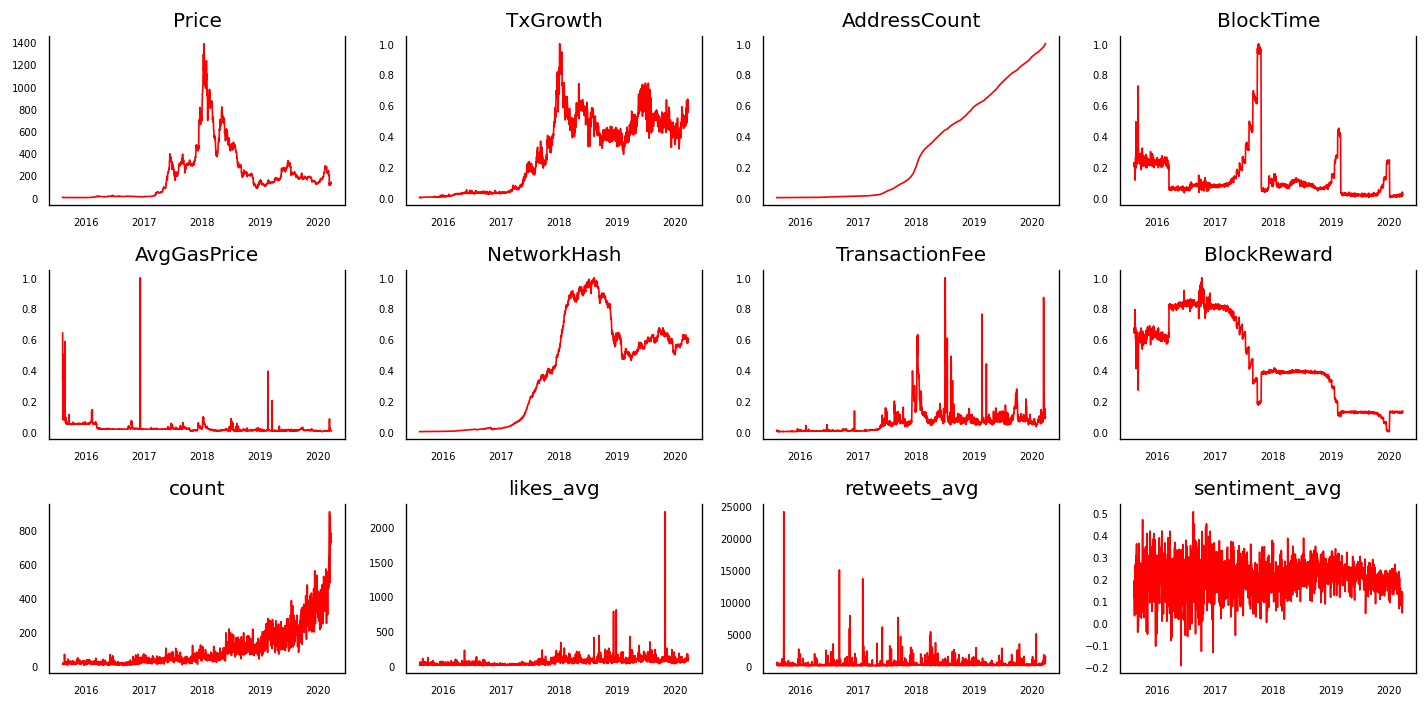

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, dpi=120, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    data = df3[df3.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df3.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
fig.tight_layout()
plt.show();

# Export data accessible by RapidMiner (or so) for further analysis
1. store_timeseries() stores data for custom date range
2. store_timeseries_binary() stores binary classification data (1 for PriceUp and 0 for PriceDown) for custom date range 

In [9]:
def store_timeseries(df3, date1, date2):
    f = 'data/res_timeseries' + date1.replace('-', '') + '_' + date2.replace('-', '') + '.csv'
    df3[date1:date2].to_csv(f)
    print('Successfully exported to:', f)
    
def store_timeseries_binary(df3, date1, date2):
    f = 'data/res_timeseries' + date1.replace('-', '') + '_' + date2.replace('-', '') + '_binary' + '.csv'
    form = '%Y-%m-%d'
    date0 = (datetime.strptime(date1, form) - timedelta(days=1)).strftime(form)
    df4 = df3[date1:date2].copy()
    del df4['Price']
    df4['PriceChange'] = df3[date0:date2].Price.diff().dropna().apply(lambda x: int(x > 0))
    df4.to_csv(f)
    print('Successfully exported to:', f)
    
store_timeseries(df3, '2019-01-01', '2019-12-31')
store_timeseries_binary(df3, '2019-01-01', '2020-03-24')

Successfully exported to: data/res_timeseries20190101_20191231.csv
Successfully exported to: data/res_timeseries20190101_20200324_binary.csv


# Perform Granger causality tests

In [10]:
maxlag = 7

# low p-value means x granger-causes y
def granger_causality_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

res_g = granger_causality_matrix(df3, variables=df3.columns)
print("---- Printing full Granger causality matrix ----")
res_g
# TxGrowth, AddressCount, TransactionFee -> GRANGER-CAUSES -> Price
# count -> GRANGER-CAUSES -> TxGrowth, AddressCount, TransactionFee
# likes_avg -> GRANGER-CAUSES -> AddressCount, TransactionFee
# likes_avg, retweets_avg, sentiment_avg -> GRANGER-CAUSES -> count -- b/c news-driven market?
print('---- Printing entries where p-value is significant (means x granger-causes y) ----')
res_g[res_g < 0.05]

---- Printing full Granger causality matrix ----


,Price_x,TxGrowth_x,AddressCount_x,BlockTime_x,AvgGasPrice_x,NetworkHash_x,TransactionFee_x,BlockReward_x,count_x,likes_avg_x,retweets_avg_x,sentiment_avg_x
Price_y,1.0000,0.0004,0.0000,0.6171,0.7987,0.0627,0.0002,0.6633,0.7289,0.2034,0.7987,0.5013
TxGrowth_y,0.0000,1.0000,0.0000,0.4822,0.1919,0.0000,0.0000,0.0000,0.0000,0.1254,0.7552,0.2413
AddressCount_y,0.0000,0.0000,1.0000,0.2612,0.1890,0.0000,0.0000,0.0000,0.0000,0.0000,0.6873,0.7427
BlockTime_y,0.7737,0.2289,0.1404,1.0000,0.0634,0.0001,0.6604,0.0000,0.1439,0.4859,0.3176,0.1232
AvgGasPrice_y,0.0063,0.0000,0.0000,0.0000,1.0000,0.0000,0.0001,0.0000,0.0000,0.0019,0.7122,0.2494
NetworkHash_y,0.0000,0.0000,0.0000,0.0226,0.8339,1.0000,0.0000,0.1574,0.0541,0.4698,0.5262,0.1456
TransactionFee_y,0.0000,0.0000,0.0000,0.4274,0.0000,0.0000,1.0000,0.0000,0.0009,0.0011,0.6997,0.3858
BlockReward_y,0.4836,0.0159,0.0014,0.0000,0.0370,0.0002,0.2843,1.0000,0.1690,0.3144,0.6703,0.0314
count_y,0.1505,0.0000,0.0000,0.0536,0.2409,0.0004,0.0669,0.0000,1.0000,0.0030,0.0263,0.0069
likes_avg_y,0.0000,0.0000,0.0000,0.0000,0.0005,0.0000,0.0000,0.0000,0.0000,1.0000,0.9114,0.1144


---- Printing entries where p-value is significant (means x granger-causes y) ----


,Price_x,TxGrowth_x,AddressCount_x,BlockTime_x,AvgGasPrice_x,NetworkHash_x,TransactionFee_x,BlockReward_x,count_x,likes_avg_x,retweets_avg_x,sentiment_avg_x
Price_y,NaN,0.0004,0.0000,NaN,NaN,NaN,0.0002,NaN,NaN,NaN,NaN,NaN
TxGrowth_y,0.0000,NaN,0.0000,NaN,NaN,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN
AddressCount_y,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN
BlockTime_y,NaN,NaN,NaN,NaN,NaN,0.0001,NaN,0.0000,NaN,NaN,NaN,NaN
AvgGasPrice_y,0.0063,0.0000,0.0000,0.0000,NaN,0.0000,0.0001,0.0000,0.0000,0.0019,NaN,NaN
NetworkHash_y,0.0000,0.0000,0.0000,0.0226,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN
TransactionFee_y,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,NaN,0.0000,0.0009,0.0011,NaN,NaN
BlockReward_y,NaN,0.0159,0.0014,0.0000,0.0370,0.0002,NaN,NaN,NaN,NaN,NaN,0.0314
count_y,NaN,0.0000,0.0000,NaN,NaN,0.0004,NaN,0.0000,NaN,0.0030,0.0263,0.0069
likes_avg_y,0.0000,0.0000,0.0000,0.0000,0.0005,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN
